In [86]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp
import ipynb.fs.full.utils as utils
import ipynb.fs.full.features as features

df_train = pd.read_csv('./data/train_filtrado.csv')
# Para usarse con el submit a Kaggle
df_eval = pd.read_csv('./data/test.csv')

df_train, df_eval = features.features_de_csvs(df_train, df_eval)

df_train = df_train.sample(frac=1).reset_index(drop=True)
# df_train = utils.dolarizar_df(df_train)

df_train, df_test = utils.dividir_df_testeo(df_train, test_size=0.4)

df_test = features.llenar_nulls(df_test, hgb_mean=True, df_fill=df_train)
df_train = features.llenar_nulls(df_train, hgb_mean=True)

df_train = df_train.sample(frac=1).reset_index(drop=True)


In [82]:
# df_train['precio'] = np.log(df_train['precio'])

In [87]:
import ipynb.fs.full.features as features

# df_train = df_train.sample(frac=1).reset_index(drop=True)

df_test_f = features.features_independientes_precio(df_test)
df_test_f = features.features_dependientes_precio(df_test_f, df_train)

df_train_f = features.features_independientes_precio(df_train)
df_train_f = features.features_dependientes_precio(df_train_f, df_train)

df_test_f, cols_tipodepropiedad_ohe = features.columna_a_ohe(df_test_f, 'tipodepropiedad', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_provincia_ohe = features.columna_a_ohe(df_test_f, 'provincia', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_zona_ohe = features.columna_a_ohe(df_test_f, 'zona', df_aux=df_train_f, devolver_cols=True)

df_train_f = features.columna_a_ohe(df_train_f, 'tipodepropiedad', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'provincia', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'zona', df_aux=df_test_f)


df_train_f['fecha'] = pd.to_datetime(df_train_f['fecha']).astype(int)
df_test_f['fecha'] = pd.to_datetime(df_test_f['fecha']).astype(int)

# df_train_f = df_train_f.sample(frac=1).reset_index(drop=True)

## Búsqueda hiperparámetros

### hyperopt

In [14]:
# # features = ['habitaciones', 
# #             'garages', 
# #             'banos',
# #             'antiguedad',
# #             'metroscubiertos', 
# #             'metrostotales', 
# #             'lat', 'lng',
# #             'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']

# # features_test = ['prop_frecuente', 'top_provincia', 'promedio_precio_ciudad', 
# #                  'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
# #                  'count_id_zona', 'count_ciudad', 'puntaje', 
# #                      'count_tipo_propiedad_ciudad', 
# #                  'promedio_precio_tipo_propiedad_ciudad_gen',
# #                  'count_id_zona'
# #                  'dias_desde_datos',
# #                  'meses_desde_datos',
# #                  'porcentaje_metros',
# #                  'promedio_precio_hbg_tipo_propiedad']

# # features += features_test

# # features += cols_tipodepropiedad_ohe + cols_provincia_ohe + cols_zona_ohe

# features = ['antiguedad', 'metroscubiertos', 'metrostotales', 'lat', 'lng',
#        'metroscubiertos_log', 'diferencia_metros',
#        'promedio_metros_tipo_propiedad', 'dias_desde_datos', 'tam_ambientes',
#        'promedio_precio_ciudad_gen', 'varianza_precio_ciudad',
#        'promedio_id_zona_gen', 'varianza_id_zona', 'count_id_zona',
#        'promedio_precio_tipo_propiedad_ciudad',
#        'promedio_precio_tipo_propiedad_ciudad_gen',
#        'count_tipo_propiedad_ciudad', 'promedio_por_mes',
#        'promedio_precio_habitaciones_banos_garages',
#        'promedio_precio_hbg_tipo_propiedad',
#        'promedio_precio_hbg_tipo_propiedad_provincia', 'puntaje']


# def eval_lightgbm(args):
#     num_leaves, learning_rate, feature_fraction, bagging_fraction, bagging_freq, max_depth, test_size = args
    
#     df_train_h = df_train_f.sample(frac=1).reset_index(drop=True)
    
#     x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_h, 'precio', features, test_size=test_size)

#     lgb_train = lgb.Dataset(x_train, y_train)
#     lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)
    
#     num_leaves = int(num_leaves)
#     bagging_freq = int(bagging_freq)
#     max_depth = int(max_depth)
#     params = {
#         'boosting_type': 'gbdt',
#         'objective': 'regression',
#         'metric': {'mae'}, # Si se deja vacio se toma el ideal para llegar al 'objective'
#         'num_leaves': num_leaves,
#         'learning_rate': learning_rate,
#         'feature_fraction': feature_fraction,
#         'bagging_fraction': bagging_fraction,
#         'bagging_freq': bagging_freq,
#         'max_depth': max_depth,
#         'verbose': -1,
#     }

#     gbm = lgb.train(params,
#                     lgb_train,
#                     valid_sets=lgb_eval,
#                     num_boost_round=150,
#                     early_stopping_rounds=15,
#                     verbose_eval=-1)
    
#     y_pred_test = gbm.predict(utils.filtrar_features(df_test_f, features), num_iteration=gbm.best_iteration)
#     return utils.MAE(df_test_f['precio'].values, y_pred_test)

# space = [hp.quniform('num_leaves', 30, 180, 1), hp.uniform('learning_rate', 0.05, 0.9),
#         hp.uniform('feature_fraction', 0.10, 0.90), hp.uniform('bagging_fraction', 0.10, 0.90),
#         hp.quniform('bagging_freq', 1, 130, 1), hp.quniform('max_depth', 1, 30, 1),
#         hp.uniform('test_size', 0.05, 0.25)]

# hps = fmin(eval_lightgbm, space=space, algo=tpe.suggest, max_evals=200, verbose=1)

# display(hps)

Training until validation scores don't improve for 15 rounds
  0%|          | 0/200 [00:02<?, ?it/s, best loss: ?]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/javier/Documents/FIUBA/Datos/.venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-a39ecaa384ee>", line 79, in <module>
    hps = fmin(eval_lightgbm, space=space, algo=tpe.suggest, max_evals=200, verbose=1)
  File "/home/javier/Documents/FIUBA/Datos/.venv/lib/python3.7/site-packages/hyperopt/fmin.py", line 422, in fmin
    rval.exhaust()
  File "/home/javier/Documents/FIUBA/Datos/.venv/lib/python3.7/site-packages/hyperopt/fmin.py", line 276, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/home/javier/Documents/FIUBA/Datos/.venv/lib/python3.7/site-packages/hyperopt/fmin.py", line 241, in run
    self.serial_evaluate()
  File "/home/javier/Documents/FIUBA/Datos/.venv/lib/python3.7/site-packages/hyperopt/fmin.py", line 141, in serial_evaluate
    result = self.domain.evaluate(spe

KeyboardInterrupt: 

### RandomizedSearchCV

In [84]:
from sklearn.model_selection import RandomizedSearchCV

features = ['habitaciones', 
            'garages', 
            'banos',
            'antiguedad',
            'metroscubiertos', 
            'metrostotales',
            'lat_norm', 'lng_norm'
            'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']

features_test = ['prop_frecuente', 'top_provincia', 'promedio_precio_ciudad', 
                 'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
                 'count_id_zona', 'count_ciudad', 'puntaje', 
                     'count_tipo_propiedad_ciudad', 
                 'promedio_precio_tipo_propiedad_ciudad_gen',
                 'count_id_zona'
                 'dias_desde_datos',
                 'meses_desde_datos',
                 'porcentaje_metros',
                 'promedio_precio_hbg_tipo_propiedad']

features += features_test


lgb_params = {
    'bagging_fraction': np.arange(0.1, 0.5, 0.2),
    'bagging_frequency': np.arange(1, 20, 5),
    'feature_fraction': np.arange(0.5, 1, 0.1),
    'max_depth': np.arange(5, 40, 10),
    'min_data_in_leaf': np.arange(30, 90, 30),
    'num_leaves': np.arange(30, 430, 100),
    'learning_rate': np.arange(0.1, 1, 0.2)
}


x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=1)

rs_cv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(), 
                           param_distributions=lgb_params, 
                           cv=4, 
                           n_iter=400,
                           verbose=1)

rs_cv.fit(x_train, y_train, verbose=1)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed: 69.5min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_...
                   param_distributions={'bagging_fraction': array([0.1, 0.3]),
                                        'bagging_frequency': array([ 1,  6, 11, 16]),
               

In [85]:
rs_cv.best_params_

{'num_leaves': 330,
 'min_data_in_leaf': 30,
 'max_depth': 15,
 'learning_rate': 0.1,
 'feature_fraction': 0.7999999999999999,
 'bagging_frequency': 6,
 'bagging_fraction': 0.30000000000000004}

In [88]:
from sklearn.externals import joblib
# Guarda el modelo
joblib.dump(rs_cv, 'lightgbm_rscv_3.pkl', compress=1)

['lightgbm_rscv_3.pkl']

## Evaluación features

In [17]:
features = ['antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 
            'lat', 'lng',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']

features_test = ['prop_frecuente', 'top_provincia', 'porcentaje_metros', 'diferencia_metros', 'promedio_precio_ciudad', 
                 'promedio_por_mes', 'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
                 'promedio_precio_hbg_tipo_propiedad', 'count_id_zona', 'count_ciudad', 'puntaje', 
                 'count_tipo_propiedad', 'count_tipo_propiedad_ciudad', 
                 'promedio_precio_tipo_propiedad_ciudad_gen', 'promedio_precio_hbg_tipo_propiedad_provincia',
                 'varianza_id_zona', 'promedio_id_zona_log', 'tam_ambientes', 'metros_cubiertos_normalizados', 
                 'dias_desde_datos', 'meses_desde_datos']

features += features_test

features += cols_tipodepropiedad_ohe + cols_provincia_ohe + cols_zona_ohe

features_remove = [['lat', 'lng'], ['antiguedad'], ['habitaciones'], ['garages'], ['banos'], ['metroscubiertos'], ['metrostotales'],
                   ['prop_frecuente'], ['top_provincia'], ['porcentaje_metros'], ['diferencia_metros'], 
                   ['promedio_precio_ciudad'],  ['promedio_por_mes'], ['anio'], ['promedio_id_zona'], ['promedio_id_zona_log'],
                   ['promedio_id_zona', 'promedio_id_zona_log'], ['promedio_precio_tipo_propiedad'],  
                   ['promedio_precio_hbg_tipo_propiedad'], ['count_id_zona'], ['count_ciudad'], 
                   ['puntaje'],  ['count_tipo_propiedad'], ['count_tipo_propiedad_ciudad'],  
                   ['promedio_precio_tipo_propiedad_ciudad_gen'], ['promedio_precio_hbg_tipo_propiedad_provincia'], 
                   ['varianza_id_zona'], ['tam_ambientes'], ['metros_cubiertos_normalizados'], ['dias_desde_datos'], 
                   ['meses_desde_datos']]

hps = {'num_leaves': 330,
 'min_data_in_leaf': 30,
 'max_depth': 15,
 'learning_rate': 0.1,
 'feature_fraction': 0.7999999999999999,
 'bagging_frequency': 6,
 'bagging_fraction': 0.30000000000000004}

bagging_fraction = hps['bagging_fraction']
bagging_freq = int(hps['bagging_freq'])
feature_fraction = hps['feature_fraction']
learning_rate = hps['learning_rate']
num_leaves = int(hps['num_leaves'])
max_depth = int(hps['max_depth'])
test_size = hps['test_size']

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'mae'}, # Si se deja vacio se toma el ideal para llegar al 'objective'
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'bagging_freq': bagging_freq,
    'max_depth': max_depth,
    'verbose': 0
}


base_train = 0
base_test = 0
base_eval = 0
for i in [['None']] + features_remove:
    
    features_new = [f for f in features if f not in i]
    if len(features_new) == len(features) and i != ['None']:
        print(f'{i} no encontrado')
        conitnue
    
    x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features_new, test_size=test_size)

    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=lgb_eval,
                    num_boost_round=1000,
                    early_stopping_rounds=15,
                    verbose_eval=-1)

    y_pred_test = gbm.predict(x_test, raw_score=True, num_iteration=gbm.best_iteration)
    y_pred_train = gbm.predict(x_train, raw_score=True, num_iteration=gbm.best_iteration)
    y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features_new), num_iteration=gbm.best_iteration)

    gbm_mae_train = utils.MAE(y_train, y_pred_train)
    gbm_mae = utils.MAE(y_test, y_pred_test)
    gbm_mae_eval = utils.MAE(df_test_f['precio'].values, y_pred_eval)

    print(f"MAE LightGBM (train): {gbm_mae_train:.5f}")
    print(f"MAE LightGBM (test): {gbm_mae:.5f}")
    print(f"MAE LightGBM (eval): {gbm_mae_eval:.5f}")
    if i != ['None']:
        print(f"Overfitting (base_eval - base_test) - (eval - test) - {i}: {(base_eval - base_test) - (gbm_mae_eval - gbm_mae)}")
        print(f"Diff evaluation (base_eval - eval)                  - {i}: {base_eval - gbm_mae_eval}")
        print(f"Diff train (base_train - train)                     - {i}: {base_train - gbm_mae_train}")
    else:
        base_train = gbm_mae_train
        base_test = gbm_mae
        base_eval = gbm_mae_eval

Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[373]	valid_0's l1: 463437
MAE LightGBM (train): 330420.54456
MAE LightGBM (test): 463437.07021
MAE LightGBM (eval): 542131.32071
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[250]	valid_0's l1: 468503
MAE LightGBM (train): 369098.86807
MAE LightGBM (test): 468502.58000
MAE LightGBM (eval): 550639.72799
Overfitting (base_eval - base_test) - (eval - test) - ['lat', 'lng']: -3442.8974921668996
Diff evaluation (base_eval - eval)                  - ['lat', 'lng']: -8508.407286400441
Diff train (base_train - train)                     - ['lat', 'lng']: -38678.32351197832
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[290]	valid_0's l1: 476151
MAE LightGBM (train): 362546.59083
MAE LightGBM (test): 476150.90023
MAE LightGBM (eval): 557419.53036
Overfitting (base_eval - base_test) - (eval - test) - 

KeyboardInterrupt: 

In [8]:
df_train_f.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio', 'similares_count',
       'porcentaje_metros', 'diferencia_metros', 'intervalo_metros_totales',
       'intervalo_metros_cubiertos', 'escomercial',
       'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad',
       'tipo_propiedad_compartida', 'prop_frecuente', 'zona', 'top_provincia',
       'es_ciudad_centrica', 'promedio_metros_totales_provincia',
       'promedio_metros_cubiertos_provincia', 'anio', 'mes', 'dia',
       'trimestre', 'escualas_centros_cercanos', 'delincuencia', 'turismo',
       'es_antigua', 'cantidad_inquilinos', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'promedio_precio_provincia',


## Evaluación modelo final

In [90]:
features = ['habitaciones', 
            'garages', 
            'banos',
            'antiguedad',
            'metroscubiertos', 
            'metrostotales',
            'lat_norm', 'lng_norm'
            'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']

features_test = ['prop_frecuente', 'top_provincia', 'promedio_precio_ciudad', 
                 'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
                 'count_id_zona', 'count_ciudad', 'puntaje', 
                     'count_tipo_propiedad_ciudad', 
                 'promedio_precio_tipo_propiedad_ciudad_gen',
                 'count_id_zona'
                 'dias_desde_datos',
                 'meses_desde_datos',
                 'porcentaje_metros',
                 'promedio_precio_hbg_tipo_propiedad']

features += features_test


hps = {'num_leaves': 330,
 'min_data_in_leaf': 30,
 'max_depth': 15,
 'learning_rate': 0.1,
 'feature_fraction': 0.7999999999999999,
 'bagging_freq': 6,
 'bagging_fraction': 0.30000000000000004}

# hps = {'num_leaves': 330,
#  'min_data_in_leaf': 30,
#  'max_depth': 35,
#  'learning_rate': 0.1,
#  'feature_fraction': 0.7999999999999999,
#  'bagging_freq': 1,
#  'bagging_fraction': 0.1}


df_train_t = df_train_f
df_test_t = df_test_f

bagging_fraction = hps['bagging_fraction']
bagging_freq = int(hps['bagging_freq'])
feature_fraction = hps['feature_fraction']
learning_rate = hps['learning_rate']
num_leaves = int(hps['num_leaves'])
max_depth = int(hps['max_depth'])
min_data_in_leaf = int(hps['min_data_in_leaf'])
# test_size = 0.2

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae', # Si se deja vacio se toma el ideal para llegar al 'objective'
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'bagging_freq': bagging_freq,
    'max_depth': max_depth,
    'min_data_in_leaf': min_data_in_leaf,
    'verbose': 0
}

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_t, 'precio', features, test_size=test_size)

# lgb_train = lgb.Dataset(x_train, y_train)
# lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

# gbm = lgb.train(params,
#                 lgb_train,
#                 valid_sets=lgb_eval,
#                 num_boost_round=1000,
#                 early_stopping_rounds=25,
#                 verbose_eval=1)

gbm = lgb.LGBMRegressor(**params)
gbm.fit(x_train.values, y_train)
y_pred_train = gbm.predict(x_train)
y_pred_test = gbm.predict(x_test)
y_pred_eval = gbm.predict(utils.filtrar_features(df_test_t, features))

# y_pred_test = gbm.predict(x_test, num_iteration=gbm.best_iteration)
# y_pred_train = gbm.predict(x_train, num_iteration=gbm.best_iteration)

# y_pred_eval = gbm.predict(utils.filtrar_features(df_test_t, features), num_iteration=gbm.best_iteration)

df_test_t['target'] = y_pred_eval
# df_test_f = utils.pesificar_df(df_test_f, 'target', 'target')

gbm_mae_train = utils.MAE(y_train, y_pred_train)
gbm_mae = utils.MAE(y_test, y_pred_test)
gbm_mae_eval = utils.MAE(df_test_t['precio'].values, df_test_t['target'].values)

print(f"MAE LightGBM (train): {gbm_mae_train:.5f}")
print(f"MAE LightGBM (test): {gbm_mae:.5f}")
print(f"MAE LightGBM (eval): {gbm_mae_eval:.5f}")

MAE LightGBM (train): 436499.63042
MAE LightGBM (test): 508140.19361
MAE LightGBM (eval): 554447.19305


In [53]:
import shap 
# shap.initjs()

df_test_shap = utils.filtrar_features(df_test_f, features)

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(df_test_shap)

In [37]:
# shap.force_plot(explainer.expected_value, shap_values, df_test_shap)

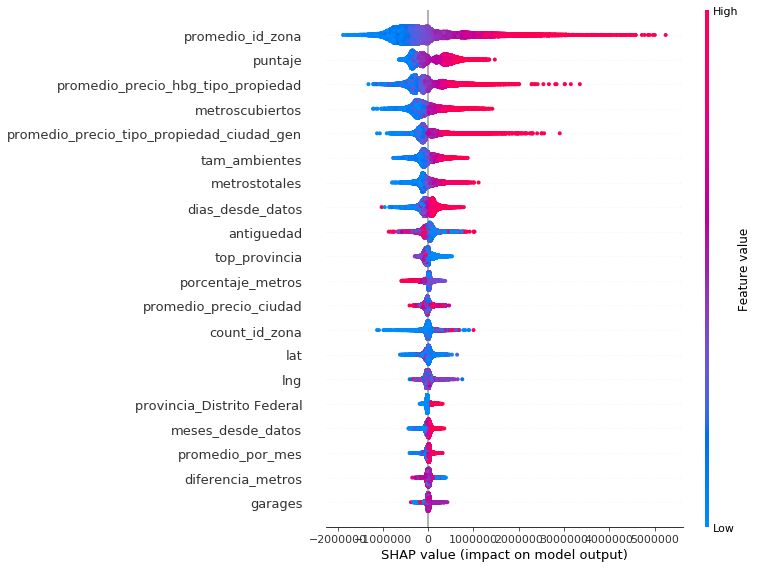

In [54]:
shap.summary_plot(shap_values, df_test_shap)

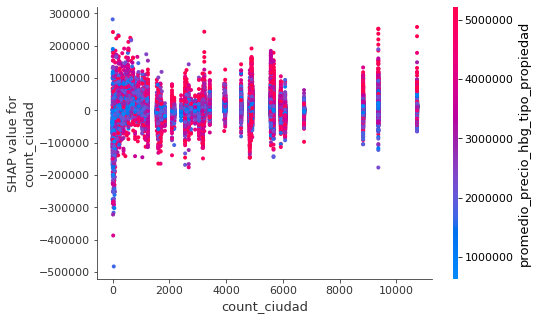

In [55]:
shap.dependence_plot("count_ciudad", shap_values, df_test_shap)

## Evaluación df_test completo

In [24]:
df_train = pd.read_csv('./data/train.csv',)

# Para usarse con el submit a Kaggle
df_test = pd.read_csv('./data/test.csv')

df_test = features.llenar_nulls(df_test, hgb_mean=True)
df_train = features.llenar_nulls(df_train, hgb_mean=True)

df_test_f = features.features_independientes_precio(df_test)
df_test_f = features.features_dependientes_precio(df_test_f, df_train)

df_train_f = features.features_independientes_precio(df_train)
df_train_f = features.features_dependientes_precio(df_train_f, df_train)

df_test_f, cols_tipodepropiedad_ohe = features.columna_a_ohe(df_test_f, 'tipodepropiedad', N=250, df_aux=df_train, devolver_cols=True)
df_test_f, cols_provincia_ohe = features.columna_a_ohe(df_test_f, 'provincia', N=250, df_aux=df_train, devolver_cols=True)
df_test_f, cols_zona_ohe = features.columna_a_ohe(df_test_f, 'zona', N=250, df_aux=df_train_f, devolver_cols=True)

df_train_f = features.columna_a_ohe(df_train_f, 'tipodepropiedad', N=250, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'provincia', N=250, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'zona', N=250, df_aux=df_test_f)

from sklearn.decomposition import PCA

pca = PCA(0.9)

features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'metrostotales_log', 'metroscubiertos_log', 'porcentaje_metros', 'diferencia_metros', 'escomercial', 'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad', 'tipo_propiedad_compartida', 'prop_frecuente', 'top_provincia', 'es_ciudad_centrica', 'promedio_metros_totales_provincia', 'promedio_metros_cubiertos_provincia', 'anio', 'mes', 'dia', 'trimestre', 'dias_desde_datos', 'meses_desde_datos', 'delincuencia', 'turismo', 'es_antigua', 'cantidad_inquilinos', 'tam_ambientes', 'metros_totales_normalizados', 'metros_cubiertos_normalizados', 'promedio_precio_provincia', 'promedio_precio_ciudad', 'promedio_precio_ciudad_gen', 'varianza_precio_ciudad', 'count_ciudad', 'promedio_id_zona', 'promedio_id_zona_log', 'promedio_id_zona_gen', 'varianza_id_zona', 'count_id_zona', 'promedio_precio_tipo_propiedad', 'promedio_precio_tipo_propiedad_ciudad', 'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad', 'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes', 'promedio_precio_habitaciones', 'promedio_precio_habitaciones_banos_garages', 'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad', 'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje', 'tipodepropiedad_Apartamento', 'tipodepropiedad_Bodega comercial', 'tipodepropiedad_Casa', 'tipodepropiedad_Casa en condominio', 'tipodepropiedad_Casa uso de suelo', 'tipodepropiedad_Departamento Compartido', 'tipodepropiedad_Duplex', 'tipodepropiedad_Edificio', 'tipodepropiedad_Inmuebles productivos urbanos', 'tipodepropiedad_Local Comercial', 'tipodepropiedad_Local en centro comercial', 'tipodepropiedad_Oficina comercial', 'tipodepropiedad_Otros', 'tipodepropiedad_Quinta Vacacional', 'tipodepropiedad_Rancho', 'tipodepropiedad_Terreno', 'tipodepropiedad_Terreno comercial', 'tipodepropiedad_Villa', 'tipodepropiedad_otro', 'provincia_Aguascalientes', 'provincia_Baja California Norte', 'provincia_Baja California Sur', 'provincia_Campeche', 'provincia_Chiapas', 'provincia_Chihuahua', 'provincia_Coahuila', 'provincia_Colima', 'provincia_Distrito Federal', 'provincia_Durango', 'provincia_Edo. de Mxico', 'provincia_Guanajuato', 'provincia_Guerrero', 'provincia_Hidalgo', 'provincia_Jalisco', 'provincia_Michoacn', 'provincia_Morelos', 'provincia_Nayarit', 'provincia_Nuevo Len', 'provincia_Oaxaca', 'provincia_Puebla', 'provincia_Quertaro', 'provincia_Quintana Roo', 'provincia_San luis Potos', 'provincia_Sinaloa', 'provincia_Sonora', 'provincia_Tabasco', 'provincia_Tamaulipas', 'provincia_Tlaxcala', 'provincia_Veracruz', 'provincia_Yucatn', 'provincia_otro', 'zona_Centro', 'zona_Norte ', 'zona_Sur'] 

x_train_red = pca.fit_transform(utils.filtrar_features(df_train_f, features))
x_test_red = pca.transform(utils.filtrar_features(df_test_f, features))

features_pca = [str(i) for i in range(len(x_train_red.T))]

df_train_f = pd.concat([df_train_f, pd.DataFrame(x_train_red, columns=features_pca)], axis=1, sort=False)
df_test_f = pd.concat([df_test_f, pd.DataFrame(x_test_red, columns=features_pca)], axis=1, sort=False)


# df_train_f['fecha'] = pd.to_datetime(df_train_f['fecha']).astype(int)
# df_test_f['fecha'] = pd.to_datetime(df_test_f['fecha']).astype(int)

features = ['habitaciones', 
            'garages', 
            'banos',
            'antiguedad',
            'metroscubiertos', 
            'metrostotales',
            'lat_norm', 'lng_norm'
            'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']

features_test = ['prop_frecuente', 'top_provincia', 'promedio_precio_ciudad', 
                 'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
                 'count_id_zona', 'count_ciudad', 'puntaje', 
                     'count_tipo_propiedad_ciudad', 
                 'promedio_precio_tipo_propiedad_ciudad_gen',
                 'count_id_zona'
                 'dias_desde_datos',
                 'meses_desde_datos',
                 'porcentaje_metros',
                 'promedio_precio_hbg_tipo_propiedad']

features += features_test


# hps = {'bagging_fraction': 0.806451877022587,
#  'bagging_freq': 62.0,
#  'feature_fraction': 0.5379925983440028,
#  'learning_rate': 0.1363027714646826,
#  'max_depth': 11.0,
#  'num_leaves': 113.0,
#  'test_size': 0.09575190901892519}


hps = {'bagging_fraction': 0.8988911725316586,
 'bagging_freq': 22.0,
 'feature_fraction': 0.6622442122619671,
 'learning_rate': 0.16422725363286422,
 'max_depth': 22.0,
 'num_leaves': 180.0,
 'test_size': 0.13892455926004772}


bagging_fraction = hps['bagging_fraction']
bagging_freq = int(hps['bagging_freq'])
feature_fraction = hps['feature_fraction']
learning_rate = hps['learning_rate']
num_leaves = int(hps['num_leaves'])
max_depth = int(hps['max_depth'])
test_size = hps['test_size']

params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': {'mae'}, # Si se deja vacio se toma el ideal para llegar al 'objective'
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'bagging_freq': bagging_freq,
    'max_depth': max_depth,
    'verbose': 0
}

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=test_size)

lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval,
                num_boost_round=1000,
                early_stopping_rounds=15,
                verbose_eval=1)

y_pred_test = gbm.predict(x_test, raw_score=True, num_iteration=gbm.best_iteration)
y_pred_train = gbm.predict(x_train, raw_score=True, num_iteration=gbm.best_iteration)
y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features), num_iteration=gbm.best_iteration)

gbm_mae_train = utils.MAE(y_train, y_pred_train)
gbm_mae = utils.MAE(y_test, y_pred_test)

print(f"MAE LightGBM (train): {gbm_mae_train:.5f}")
print(f"MAE LightGBM (test): {gbm_mae:.5f}")

[1]	valid_0's l1: 1.3927e+06
[2]	valid_0's l1: 1.21925e+06
[3]	valid_0's l1: 1.09153e+06
[4]	valid_0's l1: 981331
[5]	valid_0's l1: 892579
[6]	valid_0's l1: 825632


/home/javier/Documents/FIUBA/Datos/.venv/lib/python3.7/site-packages/lightgbm/callback.py:192: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[7]	valid_0's l1: 765596
[8]	valid_0's l1: 803541
[9]	valid_0's l1: 752696
[10]	valid_0's l1: 712492
[11]	valid_0's l1: 680441
[12]	valid_0's l1: 697052
[13]	valid_0's l1: 662396
[14]	valid_0's l1: 635487
[15]	valid_0's l1: 617388
[16]	valid_0's l1: 602341
[17]	valid_0's l1: 587637
[18]	valid_0's l1: 576107
[19]	valid_0's l1: 568302
[20]	valid_0's l1: 560245
[21]	valid_0's l1: 566675
[22]	valid_0's l1: 560083
[23]	valid_0's l1: 552922
[24]	valid_0's l1: 547454
[25]	valid_0's l1: 543481
[26]	valid_0's l1: 539437
[27]	valid_0's l1: 535831
[28]	valid_0's l1: 537808
[29]	valid_0's l1: 534468
[30]	valid_0's l1: 531774
[31]	valid_0's l1: 533299
[32]	valid_0's l1: 530776
[33]	valid_0's l1: 528746
[34]	valid_0's l1: 526574
[35]	valid_0's l1: 528325
[36]	valid_0's l1: 534938
[37]	valid_0's l1: 531494
[38]	valid_0's l1: 528501
[39]	valid_0's l1: 525745
[40]	valid_0's l1: 527563
[41]	valid_0's l1: 531075
[42]	valid_0's l1: 527348
[43]	valid_0's l1: 529833
[44]	valid_0's l1: 526932
[45]	valid_0's 

[314]	valid_0's l1: 483592
[315]	valid_0's l1: 483783
[316]	valid_0's l1: 483537
[317]	valid_0's l1: 483221
[318]	valid_0's l1: 483111
[319]	valid_0's l1: 483108
[320]	valid_0's l1: 483153
[321]	valid_0's l1: 483185
[322]	valid_0's l1: 483208
[323]	valid_0's l1: 483319
[324]	valid_0's l1: 483298
[325]	valid_0's l1: 483267
[326]	valid_0's l1: 483217
[327]	valid_0's l1: 483296
[328]	valid_0's l1: 483241
[329]	valid_0's l1: 483139
[330]	valid_0's l1: 483073
[331]	valid_0's l1: 483065
[332]	valid_0's l1: 483066
[333]	valid_0's l1: 483316
[334]	valid_0's l1: 483623
[335]	valid_0's l1: 483128
[336]	valid_0's l1: 483358
[337]	valid_0's l1: 483084
[338]	valid_0's l1: 482876
[339]	valid_0's l1: 482954
[340]	valid_0's l1: 483159
[341]	valid_0's l1: 482874
[342]	valid_0's l1: 482802
[343]	valid_0's l1: 482753
[344]	valid_0's l1: 482763
[345]	valid_0's l1: 482719
[346]	valid_0's l1: 482748
[347]	valid_0's l1: 482747
[348]	valid_0's l1: 482798
[349]	valid_0's l1: 482861
[350]	valid_0's l1: 482825
[

[621]	valid_0's l1: 475400
[622]	valid_0's l1: 474690
[623]	valid_0's l1: 474841
[624]	valid_0's l1: 474771
[625]	valid_0's l1: 474763
[626]	valid_0's l1: 474751
[627]	valid_0's l1: 474707
[628]	valid_0's l1: 474715
[629]	valid_0's l1: 474605
[630]	valid_0's l1: 474507
[631]	valid_0's l1: 474614
[632]	valid_0's l1: 474755
[633]	valid_0's l1: 474648
[634]	valid_0's l1: 474575
[635]	valid_0's l1: 474558
[636]	valid_0's l1: 474638
[637]	valid_0's l1: 474471
[638]	valid_0's l1: 474375
[639]	valid_0's l1: 474280
[640]	valid_0's l1: 474290
[641]	valid_0's l1: 474194
[642]	valid_0's l1: 474114
[643]	valid_0's l1: 474218
[644]	valid_0's l1: 474091
[645]	valid_0's l1: 474193
[646]	valid_0's l1: 474219
[647]	valid_0's l1: 474235
[648]	valid_0's l1: 474145
[649]	valid_0's l1: 473478
[650]	valid_0's l1: 473414
[651]	valid_0's l1: 473565
[652]	valid_0's l1: 473449
[653]	valid_0's l1: 473379
[654]	valid_0's l1: 473336
[655]	valid_0's l1: 473411
[656]	valid_0's l1: 473488
[657]	valid_0's l1: 473466
[

[927]	valid_0's l1: 470619
[928]	valid_0's l1: 470595
[929]	valid_0's l1: 470753
[930]	valid_0's l1: 470801
[931]	valid_0's l1: 470717
[932]	valid_0's l1: 470660
[933]	valid_0's l1: 470729
[934]	valid_0's l1: 470885
[935]	valid_0's l1: 471042
[936]	valid_0's l1: 470927
[937]	valid_0's l1: 470835
[938]	valid_0's l1: 470877
[939]	valid_0's l1: 470839
[940]	valid_0's l1: 470877
[941]	valid_0's l1: 470298
[942]	valid_0's l1: 470395
[943]	valid_0's l1: 470314
[944]	valid_0's l1: 470448
[945]	valid_0's l1: 470354
[946]	valid_0's l1: 470272
[947]	valid_0's l1: 470410
[948]	valid_0's l1: 470540
[949]	valid_0's l1: 470634
[950]	valid_0's l1: 470581
[951]	valid_0's l1: 470601
[952]	valid_0's l1: 470473
[953]	valid_0's l1: 469931
[954]	valid_0's l1: 469866
[955]	valid_0's l1: 470005
[956]	valid_0's l1: 470136
[957]	valid_0's l1: 470340
[958]	valid_0's l1: 470249
[959]	valid_0's l1: 470344
[960]	valid_0's l1: 470402
[961]	valid_0's l1: 470437
[962]	valid_0's l1: 470436
[963]	valid_0's l1: 470514
[

KeyboardInterrupt: 

In [13]:
y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features), num_iteration=gbm.best_iteration)
df_test_f['target'] = y_pred_eval

# df_test_f = utils.pesificar_df(df_test_f, 'target', 'target')
df_test_f[['id', 'target']].to_csv('respuesta27.csv', index=False)

In [8]:
utils.filtrar_features(df_test_f, features).columns.equals(x_train.columns)

True

In [11]:
df_test_f.shape

(60000, 62)